In [0]:
import gym
import math
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from collections import deque

In [2]:
!pip install roboschool
import roboschool

In [3]:


env = gym.make('RoboschoolHalfCheetah-v1')


print("action space: ", env.action_space.shape[0])
print("observation space ", env.env.observation_space.shape[0])
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using: ", device)



class Critic(nn.Module):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE,HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE, 1))
    
    def forward(self,x):
        x = self.net(x)
        return x
      
class Actor(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(Actor, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE,HIDDEN_SIZE),
                                 nn.ReLU(),
                                 )
        self.mean = nn.Sequential(nn.Linear(HIDDEN_SIZE, output_shape),
                                  nn.Tanh())                    # tanh squashed output to the range of -1..1
        self.variance =nn.Sequential(nn.Linear(HIDDEN_SIZE, output_shape),
                                     nn.Softplus())             # log(1 + e^x) has the shape of a smoothed ReLU
    
    def forward(self, x):
        x = self.net(x)    
        sigma = torch.sqrt(self.variance(x).cpu())
        m = Normal(self.mean(x).cpu(), sigma)
        actions = m.sample()
        actions = torch.clamp(actions, -1, 1) # usually clipping between -1,1 but pendulum env has action range of -2,2

        logprobs = m.log_prob(actions) #for the optimization step we create a new distribution based on the new mean and variance - still taking the logprobs based on the old actions!

    
        return actions, logprobs, m
    



action space:  6
observation space  26
Using:  cuda


In [0]:
class Agent():
  def __init__(self, state_size, action_size, A_LR, C_LR, gamma, lambda_, ppo_epochs, mini_batch_size ):
    self.state_size = state_size
    self.action_size = action_size
    self.gamma = gamma
    self.lambda_ = lambda_
    self.ppo_epochs = ppo_epochs
    self.mini_batch_size = mini_batch_size
 
    self.actor = Actor(state_size, action_size).to(device)
    self.critic = Critic(state_size).to(device)
    self.a_optimizer = optim.RMSprop(params = self.actor.parameters(),lr = A_LR)
    self.c_optimizer = optim.RMSprop(params = self.critic.parameters(),lr = C_LR)
    
    
    
    

  def test_net(self, count = 10):
      rewards = 0.0
      steps = 0
      entropys = 0.0
      for _ in range(count):
          obs = env.reset()

          while True:
              obs_v = torch.from_numpy(obs).unsqueeze(0).float()

              action, _, dist = self.actor(obs_v.to(device))
              entropy = dist.entropy().detach().cpu().numpy()
              obs, reward, done, info = env.step(action[0].cpu().numpy())

              rewards += reward
              entropys += entropy.mean()
              steps += 1
              if done:
                  break

      return rewards/count, entropys/count, steps/count




  def compute_gae(self, next_value, rewards, masks, values):
      """
      lambda => 1: high variance, low bias
      lambda => 0: low variance, high bias
      """
      values.append(next_value)
      gae = 0
      disc_returns = []
      advantage = []
      for step in reversed(range(len(rewards))):
          # d = r_t +gamma*V(s_t+1) - V(s)
          delta = rewards[step] + self.gamma * values[step + 1] * masks[step] - values[step]
          # sum(lambda*gamma)^t* delta_t+1
          gae = delta + self.gamma * self.lambda_ * masks[step] * gae

          disc_returns.insert(0, gae + values[step]) # adding values since we want the returns and not the advantage yet!  A(a,s) = Q"returns" - V(s)
          advantage.insert(0, gae)

      return torch.FloatTensor(disc_returns).unsqueeze(1), torch.FloatTensor(advantage).unsqueeze(1)


  def ppo_iter(self, states, actions, log_probs, entropy, advantage, discounted_rewards):
      batch_size = len(states)

      for i in range(batch_size // self.mini_batch_size):
          rand_ids = np.random.randint(0, batch_size, self.mini_batch_size)

          yield torch.cat(states)[rand_ids], torch.cat(actions)[rand_ids], torch.cat(log_probs)[rand_ids],torch.cat(entropy)[rand_ids], advantage[rand_ids], discounted_rewards[rand_ids]



  def ppo_update(self, states, actions, log_probs, entropies, advantage, discounted_rewards, eps_clip=0.2):
    """

    """

    a_loss_batch = []
    c_loss_batch = []

    for _ in range(self.ppo_epochs):
      for states_i, old_actions, old_logprobs,entropy, advantage_i, discounted_reward_i  in self.ppo_iter(states, actions, log_probs, entropies, advantage, discounted_rewards):


        self.c_optimizer.zero_grad()
        #tran critic
        new_value = self.critic(states_i.to(device))
        c_loss = .5 * F.mse_loss(new_value, discounted_reward_i.to(device))
        c_loss.backward(retain_graph=True)
        clip_grad_norm_(self.critic.parameters(),CLIP_GRAD)
        self.c_optimizer.step()
        c_loss_batch.append(c_loss.cpu().detach().numpy())


        #train actor
        self.a_optimizer.zero_grad()
        _, _, dist = self.actor(states_i.to(device))
        new_logprobs = dist.log_prob(old_actions)



        ratio = torch.exp(new_logprobs - old_logprobs.detach())
        surr = ratio * advantage_i
        clip = torch.clamp(ratio, 1.0 - eps_clip, 1.0 + eps_clip) 

        a_loss  = - (torch.min(surr, clip*advantage_i).mean()) + ENTROPY_BONUS * entropy.mean()
        a_loss.backward(retain_graph=True)
        clip_grad_norm_(self.actor.parameters(),CLIP_GRAD)
        self.a_optimizer.step()

        a_loss_batch.append(a_loss.detach().numpy())


    return np.array(c_loss_batch).mean(), np.array(a_loss_batch).mean()

Episode: 290 | Ep_Reward: 315.51 | Average_100: 188.99 | Steps: 810.70

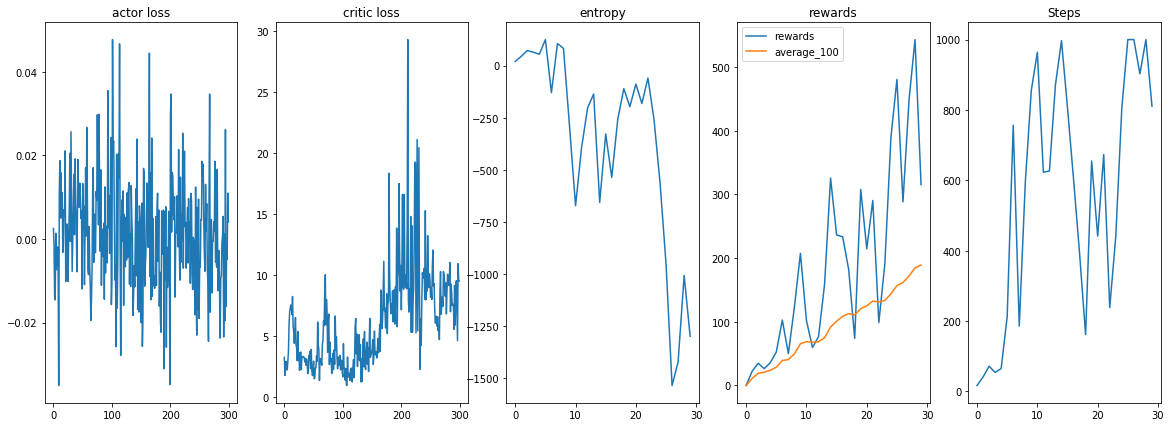

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
#env.seed(42)

state_size  = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

ENTROPY_BONUS = 0.01
CLIP_GRAD = 1
HIDDEN_SIZE = 256

agent = Agent(state_size, action_size, A_LR = 3e-4, C_LR = 3e-4, gamma = 0.99, lambda_ = 0.95, ppo_epochs = 5, mini_batch_size = 512 )

max_episodes = 300


c_loss_list = []
a_loss_list = []
entropy_list = []

step_history =[]
average_100 = []
plot_rewards = []
max_steps = 2024

for ep in range(max_episodes):
    state = env.reset()
    done = False
    
    state_batch = []
    value_batch = []
    action_batch = []
    logprob_batch = []
    entropy_batch = []
    rewards_batch = []
    masks = []
    for step in range(max_steps):

        state = torch.from_numpy(state).unsqueeze(0).float()
        action, logprob, dist  = agent.actor(state.to(device))
        entropy = dist.entropy().mean().unsqueeze(0)
        value = agent.critic(state.to(device))
        next_state, reward, done, _ = env.step(action[0].cpu().numpy())
        
        state_batch.append(state)      
        value_batch.append(value.item())
        logprob_batch.append(logprob)
        entropy_batch.append(entropy)
        action_batch.append(action)
        rewards_batch.append(reward)  
        masks.append(1 - done)

        state = next_state

        if done:
          state = env.reset()
          #break

    # calculate advantage:
    next_value = agent.critic(torch.from_numpy(next_state).unsqueeze(0).float().to(device)).item()
    discounted_rewards, advantage = agent.compute_gae(next_value, rewards_batch, masks, value_batch)
    # normalize advantage:
    advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-5)
    
    c_loss, a_loss = agent.ppo_update(states = state_batch, actions = action_batch, log_probs = logprob_batch,entropies = entropy_batch, advantage = advantage, discounted_rewards = discounted_rewards)
    c_loss_list.append(c_loss)
    a_loss_list.append(a_loss)
    
    
    if ep % 10 == 0:
      test_rewards, test_entropy, test_steps = agent.test_net()
      entropy_list.append(test_entropy)
      plot_rewards.append(test_rewards)
      step_history.append(test_steps)

      average_100.append(np.mean(plot_rewards[-100:]))
      print("\rEpisode: {} | Ep_Reward: {:.2f} | Average_100: {:.2f} | Steps: {:.2f}".format(ep, test_rewards, np.mean(plot_rewards[-100:]),test_steps), end = "", flush = True)
        
        

    

# PLOTTING RESULTS

plt.figure(figsize = (20,7))
plt.subplot(1,5,1)
plt.title("actor loss")
plt.plot(a_loss_list)
plt.subplot(1,5,2)
plt.title("critic loss")
plt.plot(c_loss_list)
plt.subplot(1,5,3)
plt.title("entropy")
plt.plot(entropy_list)
plt.subplot(1,5,4)
plt.title("rewards")
plt.plot(plot_rewards, label = "rewards")
plt.plot(average_100, label = "average_100")
plt.legend()
plt.subplot(1,5,5)
plt.title("Steps")
plt.plot(step_history)
plt.show()